1. Install and Import Dependencies

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pytesseract
import time
import pydirectinput
import gymnasium
from gymnasium.spaces import Box, Discrete
from gymnasium import Env
from mss import mss

In [2]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Set up spaces
        self.observation_space = Box(low=0, high=255, shape=(1, 83, 100), dtype=np.uint8)
        self.action_space = Discrete(3)

        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 300, 'left': 350, 'width': 350, 'height': 600}
        self.done_location = {'top': 930, 'left': 330, 'width': 300, 'height': 60}

    def seed(self, seed=None):
        self.np_random, seed = gymnasium.utils.seeding.np_random(seed)
        return [seed]

    def step(self, action):
        action_map = {
            0: 'left',
            1: 'right',
            2: 'no_op'
        }
    
        if action != 2:
            pydirectinput.press(action_map[action])
    
        done, done_cap = self.get_done()
        observation = self.get_observation()
    
        if action == 0:
            reward = 0.5
        elif action == 1:
            reward = 0.5
        else:
            reward = -1
    
        info = {'key': 'value'}
        terminated = False
    
        return observation, reward, done, terminated, info

    def reset(self, seed=None):
        # resetarea jocului
        if seed is not None:
            # setarea seed-ului
            np.random.seed(seed)
            self.seed(seed)
        # alte operații de resetare
        time.sleep(1)  # așteptăm 1 secundă
        pydirectinput.click(x=483, y=961)  # facem clic pe o anumită poziție
        observation = self.get_observation()
        info = {}
        return observation , info

    def render(self):
        cv2.imshow('Game', self.current_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    def close(self):
        cv2.destroyAllWindows()

    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100, 83))
        channel = np.reshape(resized, (1, 83, 100))

        return channel

    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['PLAY']
        done = False

        res = pytesseract.image_to_string(done_cap)[:4]

        if res in done_strings:
            done = True

        return done, done_cap

Test Env

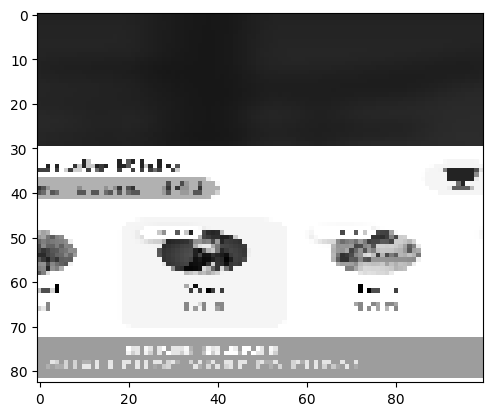

In [3]:
env = WebGame()
obs=env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

Test Env DONE

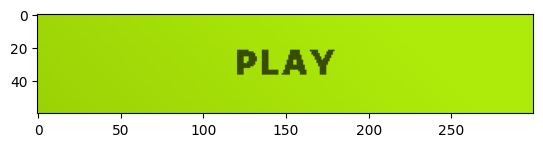

In [4]:
done, done_cap = env.get_done()
plt.imshow(done_cap)

In [5]:
done

True

Test if The ENV is working

In [6]:
for episode in range(2): 
    obs = env.reset()
    done = False  
    total_reward = 0
    done = False
    while not done: 
        observation, reward, done, terminated, info = env.step(env.action_space.sample())
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))

Total Reward for episode 0 is -5.0
Total Reward for episode 1 is 1.0


3. Train the Model

In [7]:
# Import os for file path management
import os 
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
# Check Environment    
from stable_baselines3.common import env_checker

In [8]:
env_checker.check_env(env)

In [9]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [10]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)


4 Build DQN and Train

In [11]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
env = WebGame()
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=10, learning_starts=100)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:
model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/DQN_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.5     |
|    ep_rew_mean      | 0.125    |
|    exploration_rate | 0.449    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 33       |
|    total_timesteps  | 58       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 11.4     |
|    ep_rew_mean      | -0.688   |
|    exploration_rate | 0.136    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 51       |
|    total_timesteps  | 91       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.3     |
|    ep_rew_mean      | 0.417    |
|    exploration_rate | 0.05     |
| time/               |        